In [1]:
from train_fn import train
import torch

In [2]:
result, model = train((2,0.1,1e-3,16))

importing gpu Mamba


/home/m.lavaud/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 5: 100%|██████████| 50/50 [00:45<00:00,  1.10batch/s, loss=0.00435]


In [3]:
result

{'bi_mamba_stacks': 2,
 'n_layers': 16,
 'dropout': 0.1,
 'learning_rate': 0.001,
 'running_regression_total_loss': [0.015619760677218437,
  0.008866806644946337,
  0.007136575980111957,
  0.005926635945215821,
  0.0051892228098586205,
  0.0046036372194066645],
 'running_test_loss': [0.0011724085360765458,
  0.0008704920578747988,
  0.0008000662503764033,
  0.0006011683261021971,
  0.0006373609369620681,
  0.0005545417848043144]}

In [4]:
torch.randn(10,4000,1).size()

torch.Size([10, 4000, 1])

In [5]:
model
model.eval()

EmetMamba(config=EmetConfig(d_model=3, n_layers=16, dt_rank=1, d_state=16, expand_factor=2, d_conv=4, dt_min=0.001, dt_max=0.1, dt_init='random', dt_scale=1.0, rms_norm_eps=1e-05, bias=False, conv_bias=True, inner_layernorms=False, pscan=True, use_cuda=True, bi_mamba_stacks=2, conv_stack=16, dropout=0.1))

In [6]:
from train_fn import list_directory_tree_with_pathlib

In [7]:
data_path = "../public_data_validation_v1/track_2/"

directory_files = list_directory_tree_with_pathlib(data_path)

In [8]:
directory_files

[PosixPath('../public_data_validation_v1/track_2/exp_10/trajs_fov_29.csv'),
 PosixPath('../public_data_validation_v1/track_2/exp_10/trajs_fov_21.csv'),
 PosixPath('../public_data_validation_v1/track_2/exp_10/trajs_fov_22.csv'),
 PosixPath('../public_data_validation_v1/track_2/exp_10/trajs_fov_15.csv'),
 PosixPath('../public_data_validation_v1/track_2/exp_10/trajs_fov_5.csv'),
 PosixPath('../public_data_validation_v1/track_2/exp_10/trajs_fov_26.csv'),
 PosixPath('../public_data_validation_v1/track_2/exp_10/trajs_fov_24.csv'),
 PosixPath('../public_data_validation_v1/track_2/exp_10/trajs_fov_23.csv'),
 PosixPath('../public_data_validation_v1/track_2/exp_10/trajs_fov_17.csv'),
 PosixPath('../public_data_validation_v1/track_2/exp_10/trajs_fov_20.csv'),
 PosixPath('../public_data_validation_v1/track_2/exp_10/trajs_fov_10.csv'),
 PosixPath('../public_data_validation_v1/track_2/exp_10/trajs_fov_19.csv'),
 PosixPath('../public_data_validation_v1/track_2/exp_10/trajs_fov_2.csv'),
 PosixPath('..

In [9]:
file = directory_files[0]

In [10]:
file

PosixPath('../public_data_validation_v1/track_2/exp_10/trajs_fov_29.csv')

In [11]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import pandas as pd
import numpy as np
from dataclasses import dataclass


# Function to pad an array to a specific shape
def to_shape(a, shape):
    # Unpack the target shape
    y_, x_ = shape

    # Get the current shape of the array
    y, x = a.shape

    # Calculate the padding needed in the y and x directions
    y_pad = y_ - y
    x_pad = x_ - x
    output = np.zeros()
    # Pad the array using numpy's pad function
    return np.pad(
        a,
        [(0, 1), (0, 1)],
        # Calculate the padding for each dimension
        #((y_pad // 2, y_pad // 2 + y_pad % 2), (x_pad // 2, x_pad // 2 + x_pad % 2)),
        mode="constant",
    )


# Function to pad data and labels to a specific shape
def apply_padding(data_df, N, T_max):
    # Define the final shape of the data and labels
    final_shape = (N, T_max, 3)

    # Initialize the final data and labels with zeros
    final_data = np.zeros(final_shape)
    final_label = np.zeros((N, T_max, 3))

    # Select a random subset of trajectory indices
    if len(data_df["traj_idx"].unique()) < N:
        selected_ids = data_df["traj_idx"].unique()
    else:
        selected_ids = np.random.choice(
            data_df["traj_idx"].unique(), size=N, replace=False
        )

    # Iterate over the selected trajectory indices
    for n, id in enumerate(selected_ids):
        # Filter the data for the current trajectory index
        exp = data_df[data_df["traj_idx"] == id]

        # Extract the data and labels for the current trajectory
        data = exp[["frame", "x", "y"]].to_numpy()
        # print(exp["frame"])
        label = exp[["alpha", "D", "state"]].to_numpy()

        # If the data is longer than T_max, truncate it
        if data.shape[0] > T_max:
            final_data[n, :, :] = data[:T_max, :]
            final_label[n, :, :] = label[:T_max, :]

        # Otherwise, pad the data to T_max
        else:
            # print((label.shape, T_max))
            final_data[n, :data.shape[0], :] = data
            final_label[n, :data.shape[0], :] = label

    # Return the padded data and labels
    return final_data, final_label


# Define a function to normalize data
def normalize_df(data):
    # Calculate displacement in x and y directions
    # Normalize by substring mean and dividing by variance.

    displacement_x = []
    displacement_y = []
    for _, group in data.groupby("traj_idx"):
        x = np.asarray(group["x"])
        y = np.asarray(group["y"])
        d_x = x[1:] - x[:-1]
        d_y = y[1:] - y[:-1]
        displacement_x = displacement_x + list(d_x)
        displacement_y = displacement_y + list(d_y)

    # Calculate variance in x and y directions
    variance_x = np.sqrt(np.std(displacement_x))
    variance_y = np.sqrt(np.std(displacement_y))

    # Normalize data
    data.loc[:, "x"] = (data["x"] - data["x"].mean()) / variance_x
    data.loc[:, "y"] = (data["y"] - data["y"].mean()) / variance_y


def normalize_np(data):

    displacement_x = []
    displacement_y = []
    for n in range(data.shape[0]):
        x = data[n, :, 1]
        y = data[n, :, 2]
        d_x = x[1:] - x[:-1]
        d_y = y[1:] - y[:-1]
        displacement_x = displacement_x + list(d_x)
        displacement_y = displacement_y + list(d_y)

    # Calculate variance in x and y directions
    variance_x = np.sqrt(np.std(displacement_x))
    variance_y = np.sqrt(np.std(displacement_y))

    # Normalize data

    data[:, :, 1] = (data[:, :, 1] - np.mean(data[:, :, 1])) / variance_x
    data[:, :, 2] = (data[:, :, 2] - np.mean(data[:, :, 2])) / variance_x

    return data


# Define a function to list directory tree with pathlib
def list_directory_tree_with_pathlib(starting_directory):
    path_object = Path(starting_directory)
    folders = []
    for file_path in path_object.rglob("*.csv"):
        folders.append(file_path)
    return folders


# Define a custom dataset class for all data
@dataclass
class Dataset_all_data(Dataset):
    # Initialize filenames and transform flag
    # Pad value should be a tuple such as (N, Tmax)
    filenames: list
    transform: bool = False
    pad: None | tuple = None
    noise: bool = False

    def __len__(self):
        # Return the number of files
        return len(self.filenames)

    def __getitem__(self, idx):
        # Read csv file and extract data and label
        df = pd.read_csv(self.filenames[idx])

        if self.pad is None:
            data = df[["traj_idx", "frame", "x", "y"]]
            label = np.asarray(df[["alpha", "D"]])
            label_2 = np.asarray(df["state"])

        else:
            if len(self.pad) != 2:
                raise ValueError("pad value should be set as (N, T_max)")
            data, label = apply_padding(df, *self.pad)
            label_2 = label[:, :, -1]
            label_2[label_2[:, :] > 0] = label_2[label_2[:, :] > 0] 
            label = label[:, :, :-1]

        # Normalize data if transform flag is True
        if self.transform:
            if self.pad is None:
                normalize_df(data)
                data = np.asarray(data)
            else:
                data = normalize_np(data)

        if self.noise:
            data = add_noise(data)
        
        # Normalize D between 0 and 1
        label[:,:,0] = (np.log(label[:,:,0]) + 6) / 18

        # Normaliza alpha between 0 and 1
        label[:,:,1] = label[:,:,1] / 2

        # Return data and label
        return torch.from_numpy(data.astype(np.float32)), (
            torch.from_numpy(label.astype(np.float32)),
            torch.from_numpy(label_2.astype(np.float32)),
        )
    
def add_noise(data):
    noise_amplitude = np.random.choice([0.01, 0.1, 1])
    noise = np.random.normal(0, noise_amplitude, data[:,:,1:].shape)
    data[:,:,1:] = data[:,:,1:] + data[:,:,1:]*noise
    return  data

In [12]:
df = pd.read_csv(file)
nb_trajs = len(df["traj_idx"].unique())
dataset = np.zeros((np.ceil(nb_trajs/20).astype(int), 20, 200,3))


In [13]:
## The bodel take data per batch of 20 so we should take the data and scatter it onto the batch dimension

In [14]:
dataset.shape

(3, 20, 200, 3)

In [15]:
def apply_padding(data_df):
    # Define the finaT_l shape of the data and labels
    T_max = 200
    selected_ids = data_df["traj_idx"].unique()

    final_shape = (len(selected_ids), T_max, 3)

    # Initialize the final data and labels with zeros
    final_data = np.zeros(final_shape)


    # Iterate over the selected trajectory indices
    for n, id in enumerate(selected_ids):
        # Filter the data for the current trajectory index
        exp = data_df[data_df["traj_idx"] == id]

        # Extract the data and labels for the current trajectory
        data = exp[["frame", "x", "y"]].to_numpy()
        # print(exp["frame"])

        # If the data is longer than T_max, truncate it
        if data.shape[0] > T_max:
            final_data[n, :, :] = data[:T_max, :]

        # Otherwise, pad the data to T_max
        else:
            # print((label.shape, T_max))
            final_data[n, :data.shape[0], :] = data
    # Return the padded data and labels
    return final_data


In [16]:
df_padded = apply_padding(df)

In [17]:
df_padded.shape

(41, 200, 3)

In [18]:
if nb_trajs % 20 == 0:

    for i in range(dataset.shape[0]):
        dataset[i,:,:,:] = df_padded[i*20:(i+1)*20, :,:]

else : 
    for i in range(dataset.shape[0] - 1):
        dataset[i,:,:,:] = df_padded[i*20:(i+1)*20, :,:]

    #On place i dans la dernière couche
    i+=1
    remaining_trajs = nb_trajs % 20
    dataset[i,:remaining_trajs,:,:] = df_padded[-remaining_trajs:, :, :]
    dataset[i,remaining_trajs:,:,:] = df_padded[:(20 - remaining_trajs), :, :]

In [19]:
dataset[2,:,:,:]

array([[[  0.        , 110.2262813 , 125.22570761],
        [  1.        , 112.08586866, 124.45767125],
        [  2.        , 109.53163452, 123.18154445],
        ...,
        [197.        , 115.87772769, 124.72140062],
        [198.        , 116.40646683, 124.38970044],
        [199.        , 117.61774287, 124.58487686]],

       [[  0.        ,  80.18860091, 128.26765266],
        [  1.        ,  78.65663893, 126.54661351],
        [  2.        ,  77.61759335, 128.41630385],
        ...,
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ]],

       [[174.        ,  56.81689274, 120.0316314 ],
        [175.        ,  56.64991595, 119.08786542],
        [176.        ,  58.49707388, 118.68593034],
        ...,
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ]],

       ...,

      

In [20]:
def read_dataset(file):
    df = pd.read_csv(file)
    nb_trajs = len(df["traj_idx"].unique())
    dataset = np.zeros((np.ceil(nb_trajs/20).astype(int), 20, 200,3))

    df_padded = apply_padding(df)

    if nb_trajs % 20 == 0:

        for i in range(dataset.shape[0]):
            dataset[i,:,:,:] = df_padded[i*20:(i+1)*20, :,:]

    else : 
        for i in range(dataset.shape[0] - 1):
            dataset[i,:,:,:] = df_padded[i*20:(i+1)*20, :,:]

        #On place i dans la dernière couche
        i+=1
        remaining_trajs = nb_trajs % 20
        dataset[i,:remaining_trajs,:,:] = df_padded[-remaining_trajs:, :, :]
        dataset[i,remaining_trajs:,:,:] = df_padded[:(20 - remaining_trajs), :, :]

    return torch.from_numpy(dataset.astype(np.float32)), nb_trajs

In [21]:
model.eval()

EmetMamba(config=EmetConfig(d_model=3, n_layers=16, dt_rank=1, d_state=16, expand_factor=2, d_conv=4, dt_min=0.001, dt_max=0.1, dt_init='random', dt_scale=1.0, rms_norm_eps=1e-05, bias=False, conv_bias=True, inner_layernorms=False, pscan=True, use_cuda=True, bi_mamba_stacks=2, conv_stack=16, dropout=0.1))

In [22]:
a = {}
a["2"] = 4

In [23]:
results = {}
with torch.no_grad():
    for file in directory_files:
        data, n_trajs = read_dataset(file)
        data = data.to("cuda")
        results[file] = (model(data).squeeze(),n_trajs)

In [24]:
keys = list(results.keys())

In [25]:
a = results[keys[3]][0]
n_traj = results[keys[3]][1]

In [26]:
n_traj

35

In [27]:
a = a.to("cpu").numpy()

In [28]:
a.shape

(2, 4000)

In [29]:
a =a.reshape((40,200))

In [30]:
import matplotlib.pyplot as plt

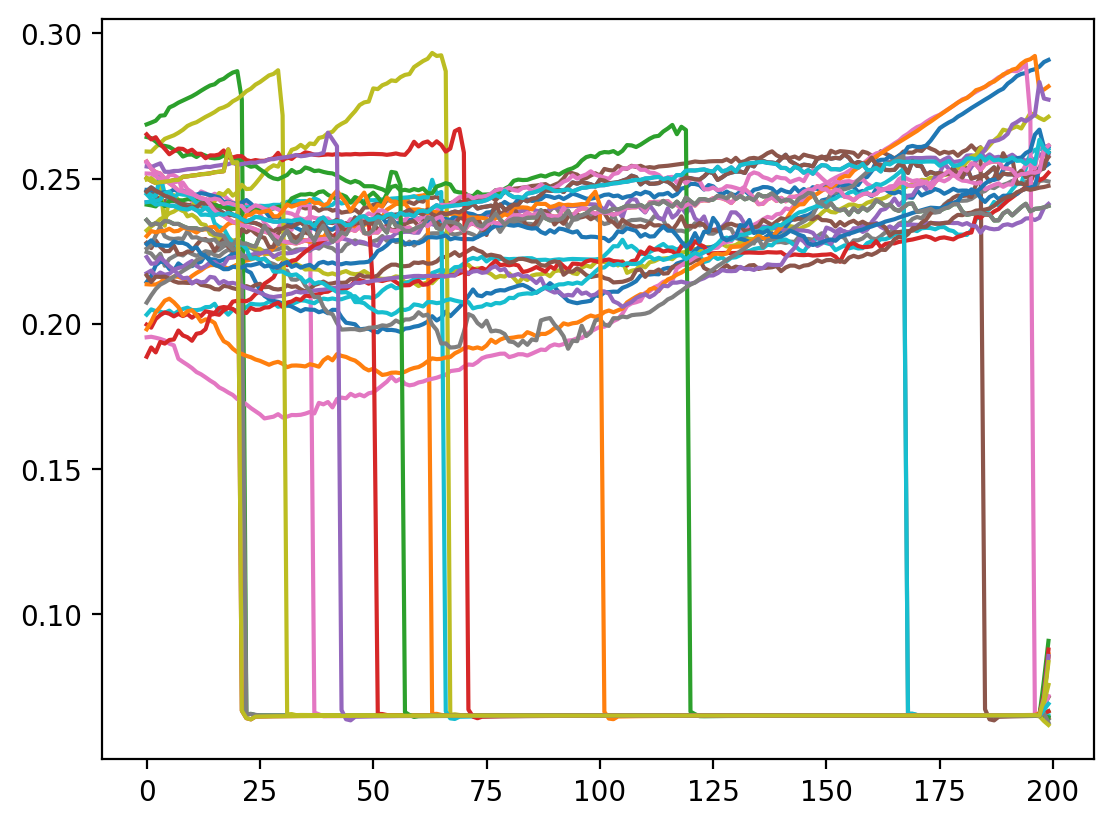

In [32]:
plt.figure(dpi=200)
for i in range(40):
    plt.plot(a[i,:])

In [ ]:
model()

array([[[0.2805348 , 0.        ],
        [0.28204185, 0.        ],
        [0.28130487, 0.        ],
        ...,
        [0.06914362, 0.        ],
        [0.06915905, 0.        ],
        [0.06915115, 0.        ]],

       [[0.28819123, 0.        ],
        [0.2877552 , 0.        ],
        [0.28726783, 0.        ],
        ...,
        [0.24553642, 0.        ],
        [0.24794024, 0.        ],
        [0.2341913 , 0.        ]]], dtype=float32)

In [ ]:
a[:,:,0].shape

(2, 4000)

In [35]:
model(data)

tensor([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]], device='cuda:0', grad_fn=<ReluBackward0>)